# Imports

Packages and dependencies

In [1]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [2]:
from src.models import *
from src.functions import *
from src.data import *
from src.rvae import *
from src.trainer import *
from src.classifier import *
from src.steps import *
from src.similarity import *

In [3]:
%load_ext autoreload
%autoreload 3

In [4]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

In [5]:
fashionmnist_trainset = datasets.FashionMNIST('data/FashionMNIST/', train=True, download=True)
fashionmnist_testset = datasets.FashionMNIST('data/FashionMNIST/', train=False, download=True)

In [6]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())

True
1.13.0+cu117
7


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Transforming Dataset 

Here you can see some examples of using the ```get_mnist_data()``` function and its output. Feel free to play around with parameters such as ```coord```, ```rotation_range```, ```translation_range```, and ```digits```. The source is found in ```src/data.py```.

In [20]:
train_data.shape

torch.Size([99, 56, 56])

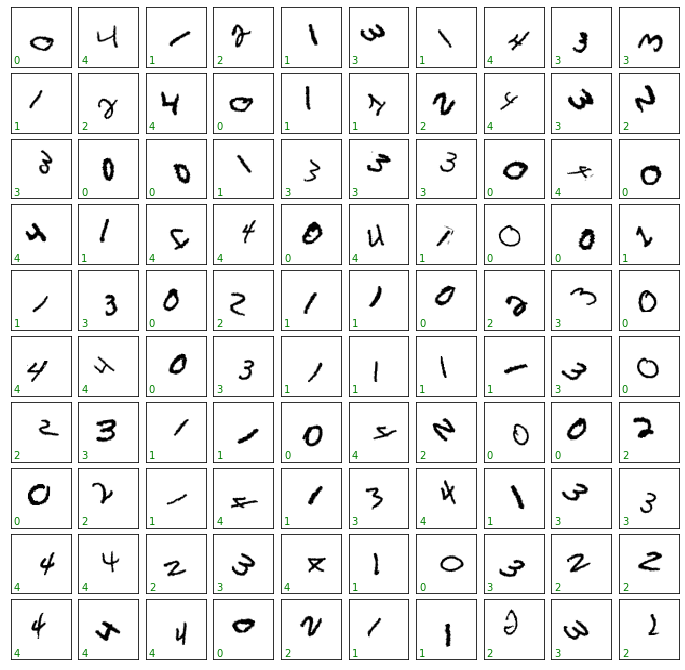

In [7]:
train_data, train_labels, angles, translations = get_mnist_data(
    mnist_trainset, 
    digits = [0,1,2,3,4],
    coord = 3,
    total_samples = 100
    )

fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

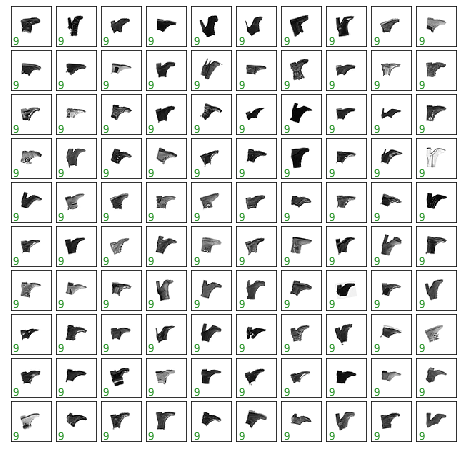

In [8]:
train_data, train_labels, angles, translations = get_mnist_data(
    fashionmnist_trainset, 
    digits = [9],
    rotation_range = [160, 201]
    )

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

# Training Models

### Trained MNIST Models

First we train all four models on all three types of transformed data on half the classes for our ROC curves. 

In [7]:
# Train on half of labels for ROC curves

# j = data_coord
# i = model_coord

# each model saved to 'saved_models/j_i_4.pkl'

for j in [1,2,3]:
    for i in [0,1,2,3]:
        # continue
        train_vae(mnist_trainset, f'{j}_{i}_4_10epoch', j, i, [0,1,2,3,4], epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.84s/it]


Epoch: 10 Training loss: 189.4501


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.98s/it]


Epoch: 10 Training loss: 175.5779


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.07s/it]


Epoch: 10 Training loss: 181.2809


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:01<00:00, 18.10s/it]


Epoch: 10 Training loss: 183.1694


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.67s/it]


Epoch: 10 Training loss: 204.5441


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.82s/it]


Epoch: 10 Training loss: 187.7983


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:02<00:00, 18.21s/it]


Epoch: 10 Training loss: 178.4093


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:03<00:00, 18.33s/it]


Epoch: 10 Training loss: 187.1482


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.83s/it]


Epoch: 10 Training loss: 227.7687


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.05s/it]


Epoch: 10 Training loss: 213.1952


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:02<00:00, 18.29s/it]


Epoch: 10 Training loss: 196.1824


100%|███████████████████████████████████████████████████████████████████| 10/10 [03:03<00:00, 18.33s/it]

Epoch: 10 Training loss: 199.4251


Then we train two models (vanilla and one of the invariants) on all three types of transformed data, on classes for cross-dataset evaluation.

In [16]:
for j in [1,2,3]:
    for i in [0,j]:
        train_vae(mnist_trainset, f'{j}_{i}_9_10epoch', j, i, epochs = 10)

100%|███████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.30s/it]


Epoch: 10 Training loss: 181.9115


100%|███████████████████████████████████████████████████████████████████| 10/10 [05:54<00:00, 35.48s/it]


Epoch: 10 Training loss: 167.2355


100%|███████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.92s/it]


Epoch: 10 Training loss: 200.6199


100%|███████████████████████████████████████████████████████████████████| 10/10 [05:55<00:00, 35.59s/it]


Epoch: 10 Training loss: 173.3301


100%|███████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.27s/it]


Epoch: 10 Training loss: 218.5563


100%|███████████████████████████████████████████████████████████████████| 10/10 [05:55<00:00, 35.54s/it]

Epoch: 10 Training loss: 199.9171


### Trained FashionMNIST Models

We do the same with the FashionMNIST dataset.

In [12]:
# Train on half of labels for ROC curves

# j = data_coord
# i = model_coord

# each model saved to 'saved_models/fj_i_4.pkl'

for j in [1,2,3]:
    for i in [0,1,2,3]:
        # continue
        train_vae(fashionmnist_trainset, f'f{j}_{i}_4_10epoch', j, i, [0,1,2,3,4], epochs=10)

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.79s/it]


Epoch: 10 Training loss: 319.7766


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.88s/it]


Epoch: 10 Training loss: 302.4922


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.94s/it]


Epoch: 10 Training loss: 330.4640


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.87s/it]


Epoch: 10 Training loss: 312.3565


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.37s/it]


Epoch: 10 Training loss: 312.7819


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.75s/it]


Epoch: 10 Training loss: 312.8860


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.67s/it]


Epoch: 10 Training loss: 299.2567


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.92s/it]


Epoch: 10 Training loss: 310.7428


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.04s/it]


Epoch: 10 Training loss: 369.7097


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.56s/it]


Epoch: 10 Training loss: 329.4740


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.90s/it]


Epoch: 10 Training loss: 336.5277


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.84s/it]

Epoch: 10 Training loss: 329.2513


In [17]:
for j in [1,2,3]:
    for i in [0,j]:
        train_vae(fashionmnist_trainset, f'f{j}_{i}_9_10epoch', j, i, epochs = 10)

100%|███████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.98s/it]


Epoch: 10 Training loss: 300.4177


100%|███████████████████████████████████████████████████████████████████| 10/10 [05:52<00:00, 35.23s/it]


Epoch: 10 Training loss: 297.2690


100%|███████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.14s/it]


Epoch: 10 Training loss: 302.5775


100%|███████████████████████████████████████████████████████████████████| 10/10 [05:51<00:00, 35.11s/it]


Epoch: 10 Training loss: 293.4283


100%|███████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.69s/it]


Epoch: 10 Training loss: 342.8163


100%|███████████████████████████████████████████████████████████████████| 10/10 [05:56<00:00, 35.65s/it]

Epoch: 10 Training loss: 328.8552


# Pair Matching

### ROC for MNIST

Here we test 'same/different' pair classification using cosine similarity of latent encodings. In each pair, the two images are the same label  (same digit), and are classified as a positive pair iff they are the same image. Effectively, this asks how well the models can distinguish different handwriting across the same digits.

Labels 0-4 are used for training and labels 5-9 are used for testing. The four VAE models are trained and tested on three different types of transformed data. In each of the three scenarios, the corresponding invariant VAE performs the best. Notice that the Rot+Trans Invariant VAE (RTInv) also performs well in the first two scenarios.

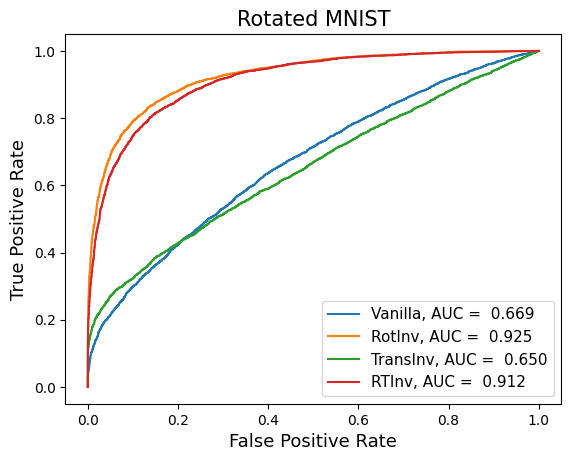

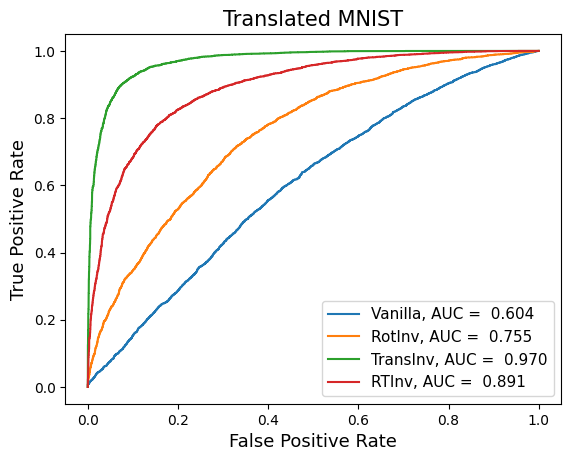

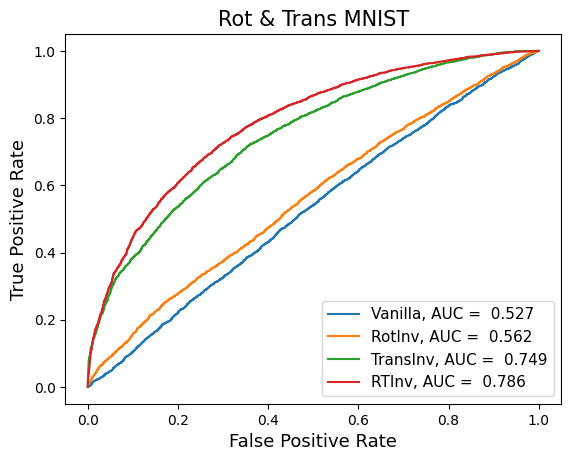

In [8]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'{j}_{i}_4_10epoch', i)
        auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} MNIST', fontsize = 15)
    plt.show()

### ROC for FashionMNIST

We perform the same tests on FashionMNIST. There are similar results for rotated data and translated data, but with less of a difference in performance. For the rotated and translated data, the TransInv VAE performs the best and the RTInv barely performs better than Vanilla. This may be due to the more complex nature of the FashionMNIST dataset, and how the data is prepared (no image padding results in considerable information loss). 

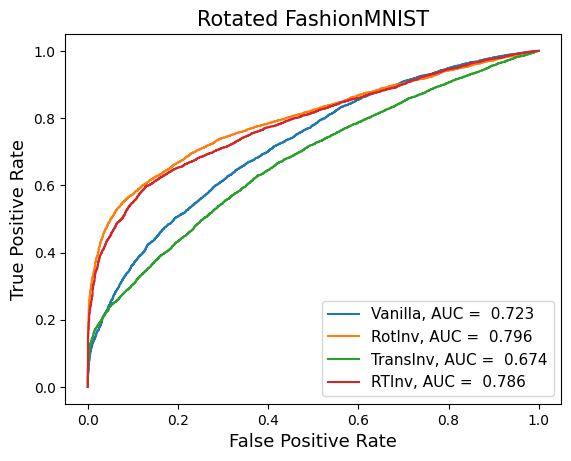

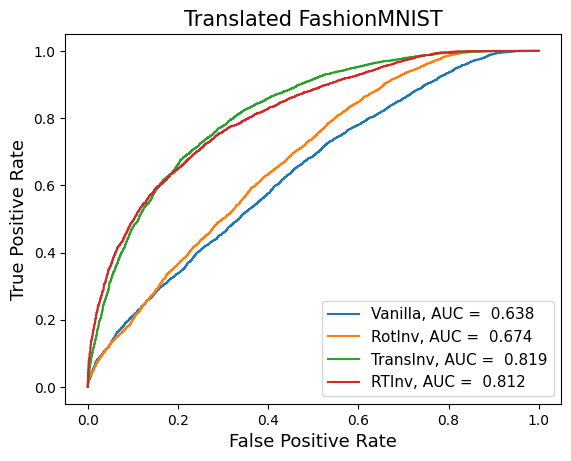

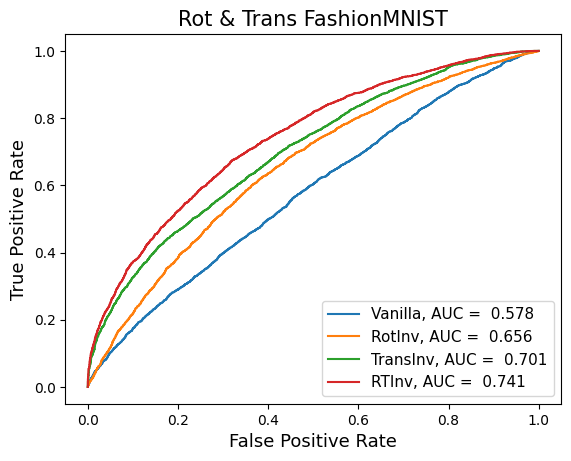

In [15]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'f{j}_{i}_4_10epoch', i)
        auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} FashionMNIST', fontsize = 15)
    plt.show()

### ROC for MNIST tested on FashionMNIST

Here we evaluate pair matching using models trained on all MNIST labels and test them on all FashionMNIST labels. In each of three settings of transformed data, we compare the vanilla VAE to the corresponding invariant VAE, which is seen to always perform better (however with minimal margins in translated settings).

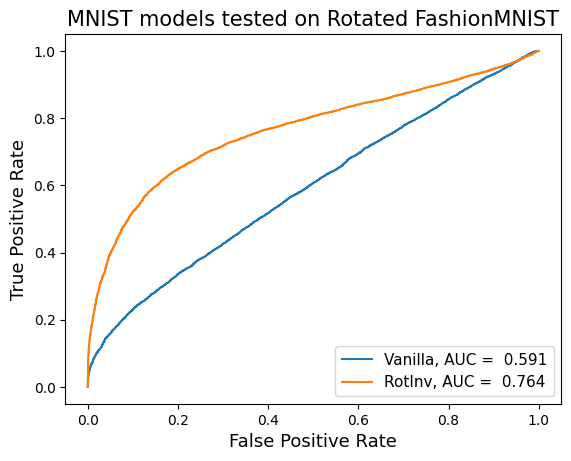

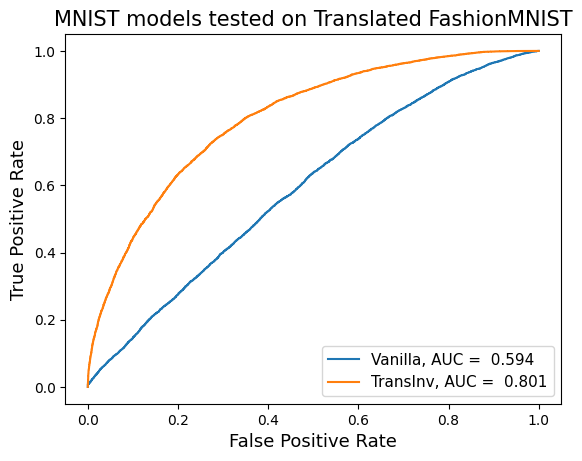

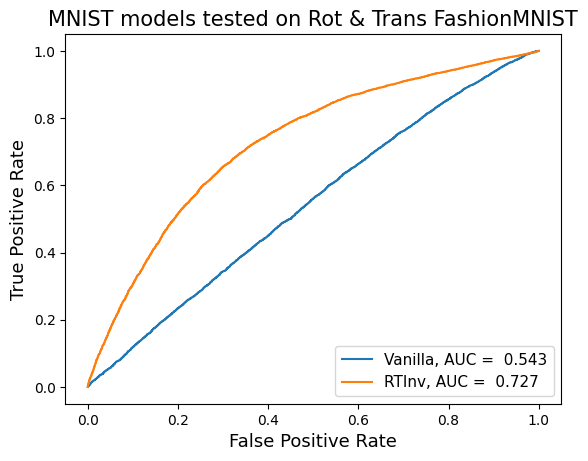

In [18]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,j]:  
        vae = load_vae(f'{j}_{i}_9_10epoch', i)
        auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [0,1,2,3,4,5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'MNIST models tested on {dataname[j]} FashionMNIST', fontsize = 15)
    plt.show()

### ROC for FashionMNIST tested on MNIST

We do the same tests as above, but instead train on FashionMNIST and test on MNIST. The invariant VAE again outperforms the vanilla VAE, but by a much narrower margin.

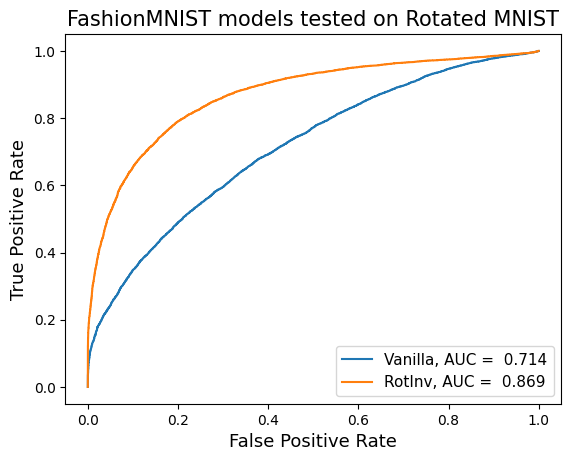

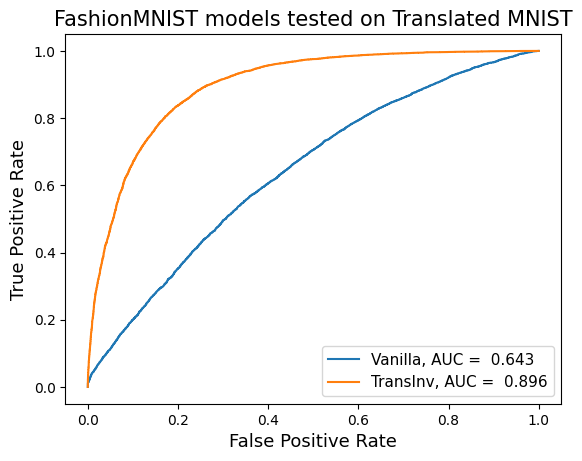

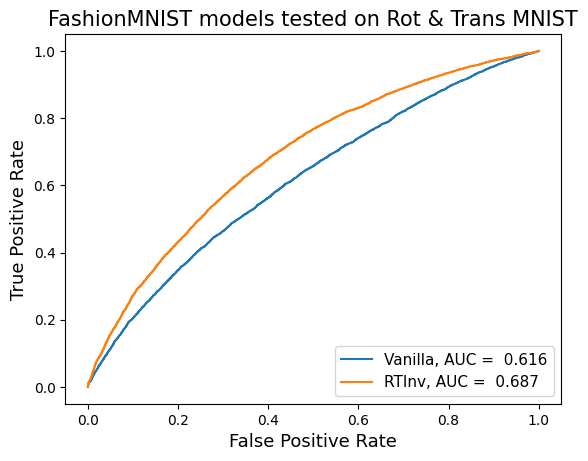

In [20]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,j]:  
        vae = load_vae(f'f{j}_{i}_9_10epoch', i)
        auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [0,1,2,3,4,5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'FashionMNIST models tested on {dataname[j]} MNIST', fontsize = 15)
    plt.show()

# Class Matching

### MNIST

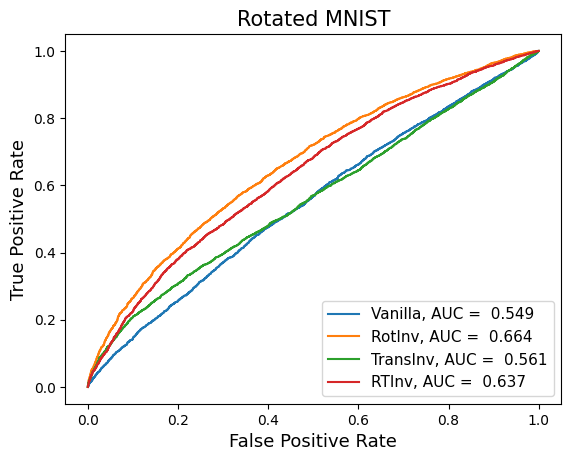

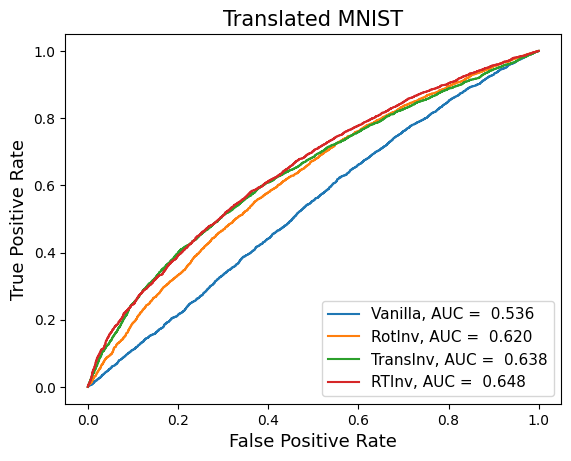

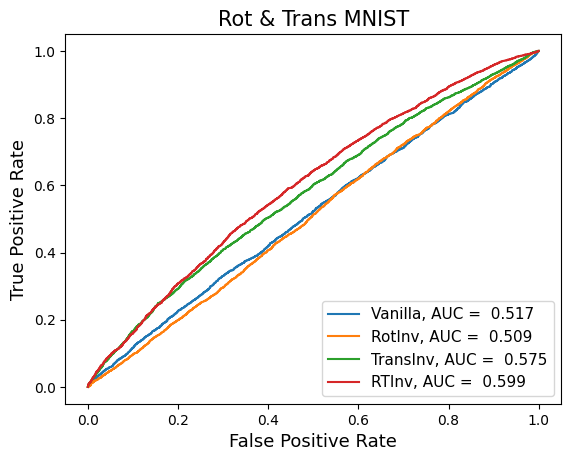

In [13]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'{j}_{i}_4_10epoch', i)
        auc, fpr, tpr, thresholds = class_matching(mnist_testset, [5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} MNIST', fontsize = 15)
    plt.show()

### FashionMNIST

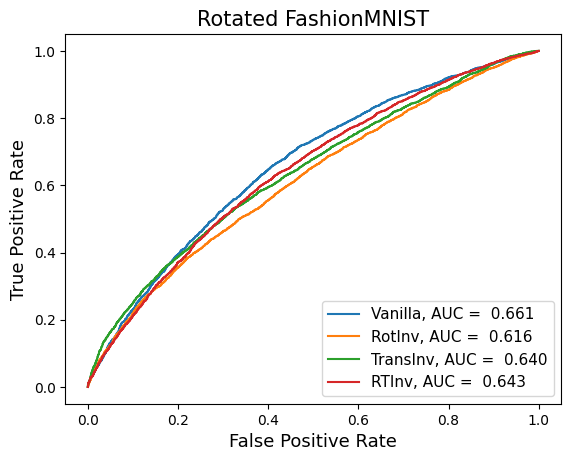

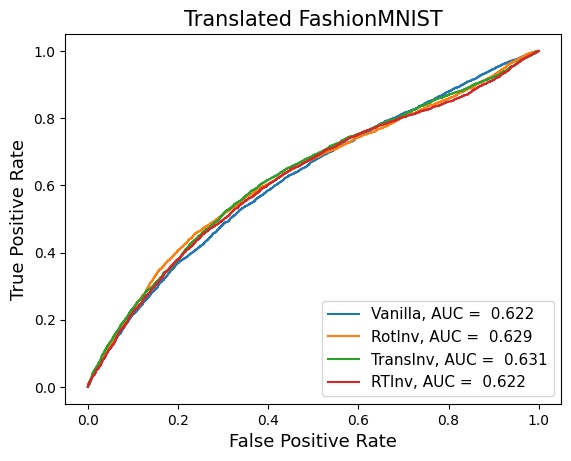

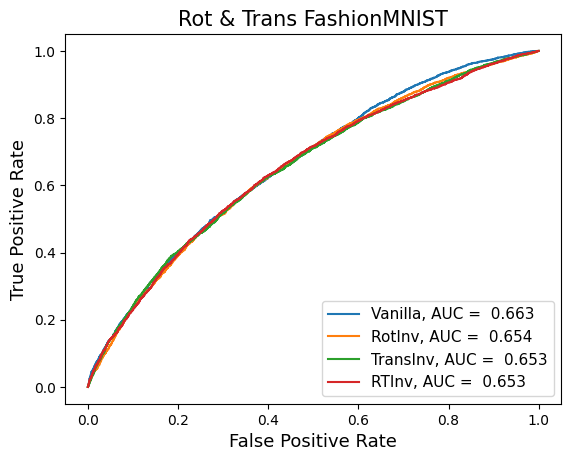

In [14]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'f{j}_{i}_4_10epoch', i)
        auc, fpr, tpr, thresholds = class_matching(fashionmnist_testset, [5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} FashionMNIST', fontsize = 15)
    plt.show()